In [2]:
import pandas as pd
import numpy as np
import warnings
import gc

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from utils.reduce_memory import trainform_columns_type

from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

### 단일 값 가지는 컬럼 & NULL 값 가지는 컬럼 모두 제거.

In [ ]:
train_df = pd.read_parquet('./data/train/train_filtered.parquet')
test_df = pd.read_parquet('./data/test/test_filtered.parquet')

print('shape of train dataset', train_df.shape)
print('shape of test dataset', test_df.shape)

# reduce memory by chaing data types of columns
train_df = trainform_columns_type(train_df)
test_df = trainform_columns_type(test_df)

print('shape of train dataset(drop colums)', train_df.shape)
print('shape of test dataset(drop colums)', test_df.shape)

ArrowMemoryError: malloc of size 12230400000 failed

(array([2121871.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  278129.]),
 array([-9.99999e+05, -8.99999e+05, -7.99999e+05, -6.99999e+05,
        -5.99999e+05, -4.99999e+05, -3.99999e+05, -2.99999e+05,
        -1.99999e+05, -9.99990e+04,  1.00000e+00]),
 <BarContainer object of 10 artists>)

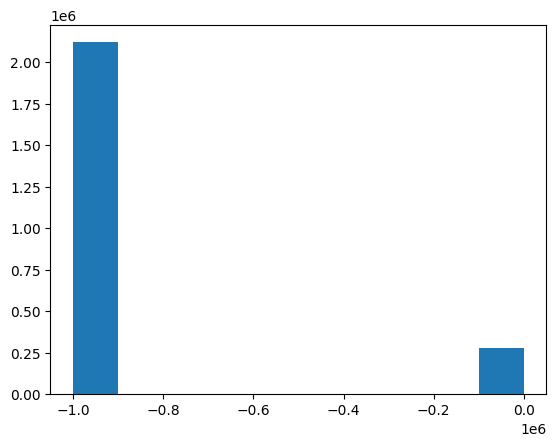

In [ ]:
# plt.hist(train_df['연체일수_B1M'])

In [ ]:
# print(train_df['연체일수_B1M'].unique())
# print(train_df['연체일수_B2M'].unique())
# print(train_df['rv최초시작후경과일'].unique())

[-999999       0       1]
[-999999       0       1]
[99999999      322     2378 ...     5299      623     4813]


In [ ]:
# train_df['연체일수_B1M'] = train_df['연체일수_B1M'].replace(-999999, -1)
# train_df['연체일수_B2M'] = train_df['연체일수_B2M'].replace(-999999, -1)
# train_df['rv최초시작후경과일'] = train_df['rv최초시작후경과일'].replace(99999999, -1)

In [6]:
print(train_df['연체일수_B1M'].unique())
print(train_df['연체일수_B2M'].unique())
print(train_df['rv최초시작후경과일'].unique())

[-1  0  1]
[-1  0  1]
[  -1  322 2378 ... 5299  623 4813]


In [7]:
# remove columns to have null values
null_cols = train_df.columns[train_df.isnull().any()]
train_df = train_df.drop(columns=null_cols)          
test_df = test_df.drop(columns=null_cols, errors='ignore')
print('shape of train dataset(drop colums to have null values)', train_df.shape)
print('shape of test dataset(drop colums to have null values)', test_df.shape)

shape of train dataset(drop colums to have null values) (2400000, 712)
shape of test dataset(drop colums to have null values) (600000, 711)


In [8]:
train_df.dtypes

기준년월                int32
ID                 object
남녀구분코드              int32
연령                 object
Segment            object
                   ...   
변동률_RVCA평잔        float32
변동률_카드론평잔         float32
변동률_잔액_B1M        float32
변동률_잔액_일시불_B1M    float32
변동률_잔액_CA_B1M     float32
Length: 712, dtype: object

## Split X, y in train datasets 분리

In [9]:
# X: ID, Segement 제거
# y: Segment 추출
feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]

X = train_df[feature_cols].copy() 
y = train_df["Segment"].copy() 
X_test = test_df.copy()

In [10]:
# Target Label Encoding
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
continous_features = X.select_dtypes(include=['float32', 'int32']).columns.tolist()


encoders = {}  # categorical encoders 저장
scalers = {}  #  continous encoders 저장
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])
    
for col in continous_features:
    std_train = StandardScaler()
    X[col] = std_train.fit_transform(X[[col]])
    scalers[col] = std_train
    X_test[col] = std_train.transform(X_test[[col]])

In [11]:
gc.collect()

0

In [12]:
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weight_dict = dict(zip(classes, weights))

In [13]:
class_weight_dict

{0: 493.82716049382714,
 1: 3333.3333333333335,
 2: 3.7620503174229953,
 3: 1.3744051402752246,
 4: 0.2497330977517778}

In [14]:
sample_weights = np.array([class_weight_dict[y] for y in y_encoded])
sample_weights

array([1.37440514, 0.2497331 , 3.76205032, ..., 3.76205032, 0.2497331 ,
       0.2497331 ])

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = [] 
accuracy_scores = []
recall_scores = []
precision_scores = []
fi_scores = []
classification_reports = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    sample_weights_fold = sample_weights[train_idx]
    print('-'*40)
    print(f'Fold {fold + 1}-th CatBoost model training...')
    
    # XGBoost
    model = CatBoostClassifier(
        iterations=400,
        task_type="GPU",
        #depth=5,
        #learning_rate=0.0005,
        random_seed=0,
        #verbose=500,
    )
    
    # training and validation mornitoring
    model.fit(X_train, y_train, 
              sample_weight=sample_weights[train_idx]
              )
    models.append(model)

    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred, average='macro')
    precision = precision_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')
    report = classification_report(y_val, y_val_pred)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} Recall: {recall:.4f}")
    print(f"Fold {fold + 1} Precision: {precision:.4f}")
    print(f"Fold {fold + 1} F1-score: {f1:.4f}")
    print(f"Fold {fold + 1} Classification Report\n:{report}")
    print(f"Fold {fold + 1} Confusion Matrix:\n{conf_matrix}")
    print('-'*40)
    
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    fi_scores.append(f1)
    
    
print(f"K-Fold mean Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"K-Fold mean Recall: {np.mean(recall_scores):.4f}")
print(f"K-Fold mean Precision: {np.mean(precision_scores):.4f}")
print(f"K-Fold mean F1-score: {np.mean(fi_scores):.4f}")

----------------------------------------
Fold 1-th CatBoost model training...
Learning rate set to 0.5
0:	learn: 0.9211371	total: 175ms	remaining: 1m 9s
1:	learn: 0.7284408	total: 230ms	remaining: 45.8s
2:	learn: 0.6332052	total: 279ms	remaining: 36.9s
3:	learn: 0.5712945	total: 346ms	remaining: 34.2s
4:	learn: 0.5328652	total: 404ms	remaining: 31.9s
5:	learn: 0.5076438	total: 439ms	remaining: 28.8s
6:	learn: 0.4911300	total: 499ms	remaining: 28s
7:	learn: 0.4723061	total: 565ms	remaining: 27.7s
8:	learn: 0.4561054	total: 609ms	remaining: 26.5s
9:	learn: 0.4459872	total: 662ms	remaining: 25.8s
10:	learn: 0.4327432	total: 720ms	remaining: 25.5s
11:	learn: 0.4241301	total: 777ms	remaining: 25.1s
12:	learn: 0.4174359	total: 840ms	remaining: 25s
13:	learn: 0.4114583	total: 913ms	remaining: 25.2s
14:	learn: 0.4044653	total: 973ms	remaining: 25s
15:	learn: 0.3968539	total: 1.02s	remaining: 24.4s
16:	learn: 0.3926022	total: 1.08s	remaining: 24.4s
17:	learn: 0.3877278	total: 1.12s	remaining: 2

In [16]:
X_test.drop(columns=['ID'],inplace=True)

In [17]:
n_classes = len(np.unique(y_encoded))
test_probabilities = np.zeros((len(X_test), n_classes)) # (600000, 5)

for model in models:
    test_probabilities += model.predict_proba(X_test) # (600000, 5)

test_probabilities /= len(models)
test_predictions = np.argmax(test_probabilities, axis=1)

print('Soft Voting Inference Done.')

Soft Voting Inference Done.


In [18]:
y_test_pred_labels = le_target.inverse_transform(test_predictions)

# row 단위 예측 결과를 test_data에 추가
test_data = test_df.copy()  # 원본 유지
test_data["pred_label"] = y_test_pred_labels

submission = test_data.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]

In [19]:
submission

,ID,Segment
0,TEST_00000,D
1,TEST_00001,E
2,TEST_00002,D
3,TEST_00003,E
4,TEST_00004,E
...,...,...
99995,TEST_99995,E
99996,TEST_99996,E
99997,TEST_99997,E
99998,TEST_99998,C


In [20]:
submission.to_csv('./results/0427_catboost_K5fold(replace_연체일수_B1M_연체일수_B2M_rv최초시작후경과일).csv',index=False)

In [22]:
best_score_df = pd.read_csv('./results/0401_catboost_K5fold(standard-scaler).csv', sep=',')
best_score = best_score_df['Segment'].to_list()
seed_score = submission['Segment'].to_list()

accuracy_score(best_score, seed_score)

0.99216